In [2]:
import os,random 
import matplotlib.pyplot as plt 
import numpy as np 
from keras.preprocessing import image

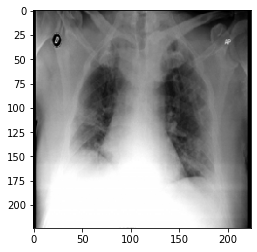

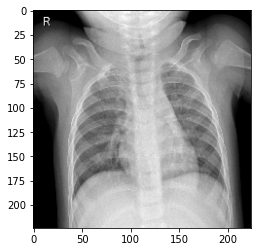

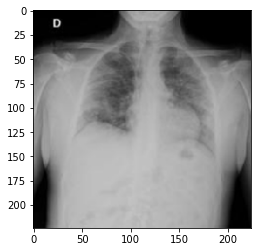

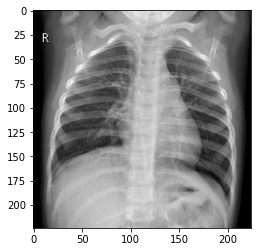

In [3]:
base_dir = 'Data/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_COVID_dir = os.path.join(train_dir, 'COVID')
train_NORMAL_dir = os.path.join(train_dir, 'NORMAL')

train_size, validation_size, test_size = 1000, 100, 100

img_width, img_height = 224, 224  # Default input size for VGG16



def show_pictures(path):
    random_img = random.choice(os.listdir(path))
    img_path = os.path.join(path, random_img)

    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
    img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application
    plt.imshow(img_tensor)
    plt.show()
    
for i in range(0,2):
    show_pictures(train_COVID_dir)
    show_pictures(train_NORMAL_dir)

In [4]:
from keras.applications import DenseNet121

conv_base = DenseNet121(weights='imagenet', 
                  include_top=False,
                  input_shape=(img_width, img_height, 3))  # 3 = number of channels in RGB pictures

In [5]:
conv_base.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

conv5_block10_concat (Concatena (None, 7, 7, 832)    0           conv5_block9_concat[0][0]        
                                                                 conv5_block10_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block11_0_bn (BatchNormal (None, 7, 7, 832)    3328        conv5_block10_concat[0][0]       
__________________________________________________________________________________________________
conv5_block11_0_relu (Activatio (None, 7, 7, 832)    0           conv5_block11_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block11_1_conv (Conv2D)   (None, 7, 7, 128)    106496      conv5_block11_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block11_1_bn (BatchNormal (None, 7, 7, 128)    512         conv5_block11_1_conv[0][0]       
__________

Total params: 7,037,504
Trainable params: 6,953,856
Non-trainable params: 83,648
__________________________________________________________________________________________________


In [6]:
import os, shutil
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 4

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1024))  # Must be equal to the output of the convolutional base
    labels = np.zeros(shape=(sample_count))
    # Preprocess data
    generator = datagen.flow_from_directory(directory,
                                            target_size=(img_width,img_height),
                                            batch_size = batch_size,
                                            class_mode='binary')
    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels
    
train_features, train_labels = extract_features(train_dir, train_size)  # Agree with our small dataset size
validation_features, validation_labels = extract_features(validation_dir, validation_size)
test_features, test_labels = extract_features(test_dir, test_size)

Found 2000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [7]:
print(train_features)
print(train_labels)

[[[[4.51878179e-04 2.03010757e-02 4.30465722e-03 ... 0.00000000e+00
    1.63267612e+00 1.32975638e-01]
   [9.36915225e-04 6.69574644e-03 7.09198369e-03 ... 0.00000000e+00
    2.21043873e+00 0.00000000e+00]
   [0.00000000e+00 6.94696559e-03 1.01590110e-03 ... 1.01955020e+00
    5.03925085e-01 0.00000000e+00]
   ...
   [7.80033879e-05 4.49416554e-03 1.09341554e-02 ... 1.09123433e+00
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 9.41894762e-03 1.09294727e-02 ... 4.36013341e-01
    0.00000000e+00 1.80639803e-01]
   [1.25447506e-04 1.96336433e-02 0.00000000e+00 ... 1.71659589e-02
    0.00000000e+00 1.05947495e-01]]

  [[1.15825399e-03 3.81692592e-03 4.35243594e-03 ... 0.00000000e+00
    2.35807586e+00 7.20471740e-01]
   [1.67498644e-03 1.70091284e-03 6.64411252e-03 ... 0.00000000e+00
    2.82573318e+00 0.00000000e+00]
   [1.87742990e-06 1.84599049e-02 3.32317082e-03 ... 5.48132181e-01
    7.73650110e-01 0.00000000e+00]
   ...
   [3.51812458e-04 6.75925240e-03 5.20406570e-03 ... 1.82

In [8]:
svm_features = np.concatenate((train_features, validation_features))
svm_labels = np.concatenate((train_labels, validation_labels))

In [9]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

X_train, y_train = svm_features.reshape(1100,7*7*1024), svm_labels

param = [{
          "C": [0.01, 0.1, 1, 10, 100]
         }]
 
svm = LinearSVC(penalty='l2', loss='squared_hinge')  # As in Tang (2013)
clf = GridSearchCV(svm, param, cv=10)
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

print("\nAccuracy score (mean):")
print(np.mean(cross_val_score(clf, X_train, y_train, cv=10)))


Accuracy score (mean):
0.9945454545454545


In [11]:
print("\nAccuracy score (standard deviation):")
print(np.std(cross_val_score(clf, X_train, y_train, cv=10)))


Accuracy score (standard deviation):
0.0060302268915552616


In [13]:
X_test, y_test = test_features.reshape(100,7*7*1024), test_labels
print("test accuracy:",clf.score(X_test,y_test))

test accuracy: 1.0


(100, 50176)


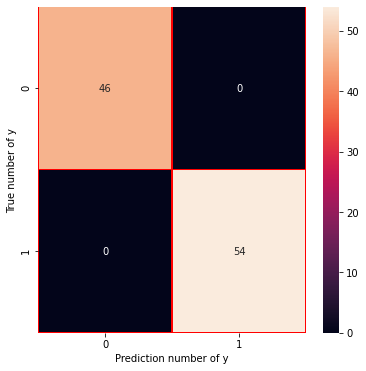

In [14]:
import seaborn as sns
print(X_test.shape)

y_prediction = clf.predict(X_test)
y_true = y_test

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_prediction)


f, ax= plt.subplots(figsize=(6,6))
sns.heatmap(cm,annot= True,linewidths=0.4,linecolor="red",fmt= ".0f",ax=ax)
plt.xlabel("Prediction number of y")
plt.ylabel("True number of y")
plt.show()


In [15]:
TP = 54
TN = 46
FP = 0
# FN (0) and TN (12) are not needed in the formuala!
precision = TP / (TP + FP)
print(f"precision: {precision:4.2f}")

precision: 1.00


In [16]:
TP = 43
FN = 0
# FT (14) and TN (12) are not needed in the formuala!
recall = TP / (TP + FN)
print(f"recall: {recall:4.2f}")

recall: 1.00


In [17]:
TF = 7
print("  FN    FP   TP     pre   acc   rec   f1")
for FN in range(0, 7):
    for FP in range(0, FN+1):
        # the sum of FN, FP, TF and TP will be 100:
        TP = 100 - FN - FP - TF
        #print(FN, FP, TP, FN+FP+TP+TF)
        precision = TP / (TP + FP)
        accuracy = (TP + TN)/(TP + TN + FP + FN)
        recall = TP / (TP + FN)
        f1_score = 2 * precision * recall / (precision + recall)
        print(f"{FN:6.2f}{FP:6.2f}{TP:6.2f}", end="")
        print(f"{precision:6.2f}{accuracy:6.2f}{recall:6.2f}{f1_score:6.2f}")

  FN    FP   TP     pre   acc   rec   f1
  0.00  0.00 93.00  1.00  1.00  1.00  1.00
  1.00  0.00 92.00  1.00  0.99  0.99  0.99
  1.00  1.00 91.00  0.99  0.99  0.99  0.99
  2.00  0.00 91.00  1.00  0.99  0.98  0.99
  2.00  1.00 90.00  0.99  0.98  0.98  0.98
  2.00  2.00 89.00  0.98  0.97  0.98  0.98
  3.00  0.00 90.00  1.00  0.98  0.97  0.98
  3.00  1.00 89.00  0.99  0.97  0.97  0.98
  3.00  2.00 88.00  0.98  0.96  0.97  0.97
  3.00  3.00 87.00  0.97  0.96  0.97  0.97
  4.00  0.00 89.00  1.00  0.97  0.96  0.98
  4.00  1.00 88.00  0.99  0.96  0.96  0.97
  4.00  2.00 87.00  0.98  0.96  0.96  0.97
  4.00  3.00 86.00  0.97  0.95  0.96  0.96
  4.00  4.00 85.00  0.96  0.94  0.96  0.96
  5.00  0.00 88.00  1.00  0.96  0.95  0.97
  5.00  1.00 87.00  0.99  0.96  0.95  0.97
  5.00  2.00 86.00  0.98  0.95  0.95  0.96
  5.00  3.00 85.00  0.97  0.94  0.94  0.96
  5.00  4.00 84.00  0.95  0.94  0.94  0.95
  5.00  5.00 83.00  0.94  0.93  0.94  0.94
  6.00  0.00 87.00  1.00  0.96  0.94  0.97
  6.00  1.00 

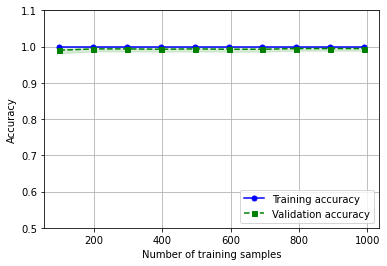

In [18]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(estimator = clf,
                                                        X = X_train,
                                                        y = y_train,
                                                        train_sizes = np.linspace(0.1,1.0,10),
                                                        cv = 10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', 
         marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')


plt.plot(train_sizes, test_mean, color='green', linestyle='--',
         marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.5, 1.1])
plt.show()

In [19]:
import joblib
filename = 'densenet121_svm.sav'
joblib.dump(clf, filename)

['densenet121_svm.sav']

In [20]:
def visualize_predictions(classifier, n_cases):
    path1='Data/test/COVID/'
    path2='Data/test/NORMAL/'
    for i in range(0,n_cases):
        path = random.choice([path1, path2])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Extract features
        features = conv_base.predict(img_tensor.reshape(1,img_width, img_height, 3))

        # Make prediction
        try:
            prediction = classifier.predict(features)
        except:
            prediction = classifier.predict(features.reshape(1, 7*7*1024))

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print('COVID')
        else:
            print('NORMAL')

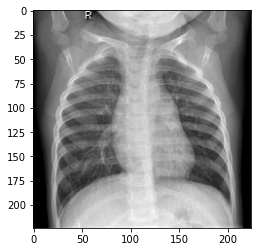

NORMAL


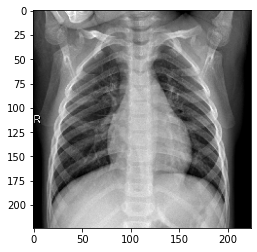

NORMAL


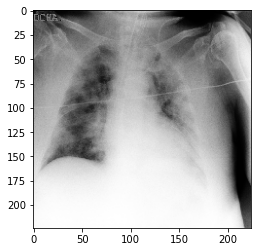

COVID


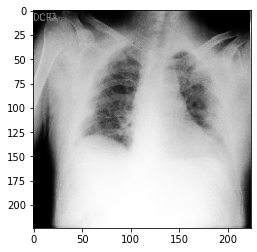

COVID


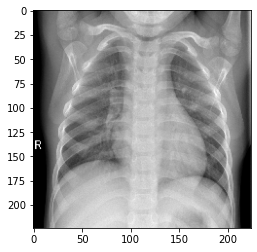

NORMAL


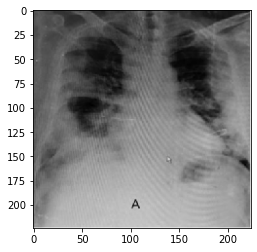

COVID


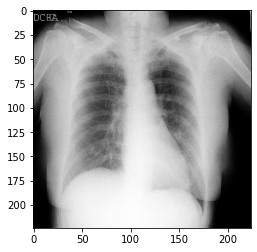

COVID


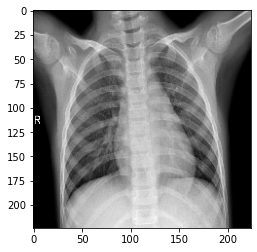

NORMAL


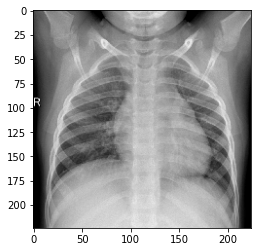

NORMAL


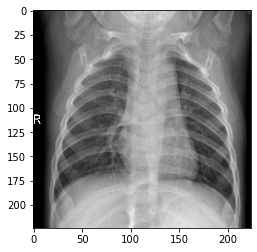

NORMAL


In [21]:
visualize_predictions(clf, 10)

